In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create the data

In [3]:
# Check the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Define some parameters of the data
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 300  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes

# Make some spiral data

In [5]:
X = torch.zeros(N * C, D).to(device)
y = torch.zeros(N * C, dtype=torch.long).to(device)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    #when c = 0 and t = 0: start of linspace
    #when c = 0 and t = 1: end of linspace
    # Theis inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = torch.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))

Shapes:
X: (900, 2)
y: (900,)


# First, a helper for plotting this data

In [6]:
from matplotlib.colors import ListedColormap

In [7]:
# cmap = ListedColormap([(0.267004, 0.004874, 0.329415,1.0),
#                        (0.163625, 0.471133, 0.558148, 1.0),
#                        (0.477504, 0.821444, 0.318195, 1.0)
#                       ])
cmap=plt.cm.viridis

In [8]:
def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=cmap)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

In [9]:
# Set the default plot size for the notebook
plt.rc('figure', figsize=(8,8), dpi=100)

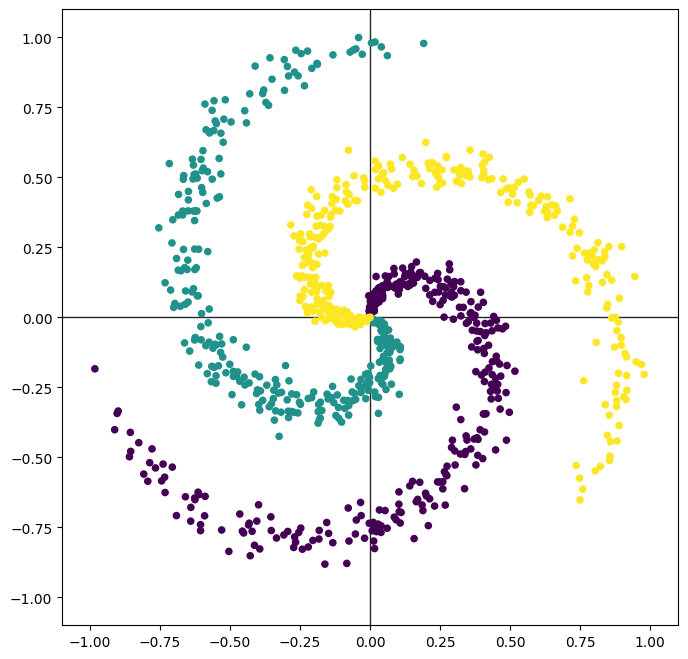

In [10]:
# visualise the data
plot_data(X, y)

# Another plotting helper function for overlaying the model on the data

# n-linear network

In [11]:
# Size of the hidden layer
H = 100

In [12]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [13]:
# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.164813, [ACCURACY]: 0.958


In [14]:
def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    plot_data(X, y)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=3, bias=True)
)


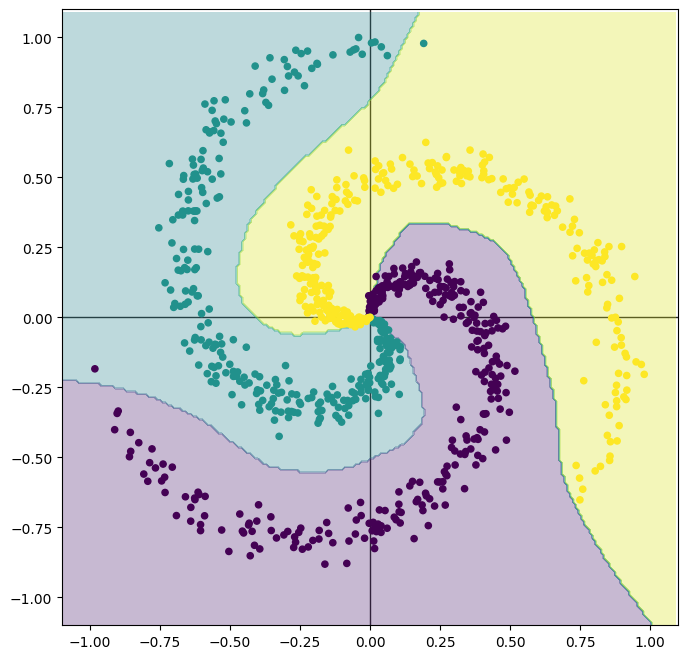

In [15]:
# Plot trained model
print(model)
plot_model(X, y, model)

# Non-linear network with additional 2D inspection layer

In [16]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [17]:

# nn package to create our linear model
# each Linear module has a weight and bias

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H, D), # <--- inspection layer
    nn.Linear(D,C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 999, [LOSS]: 0.104408, [ACCURACY]: 0.980


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): Linear(in_features=2, out_features=3, bias=True)
)


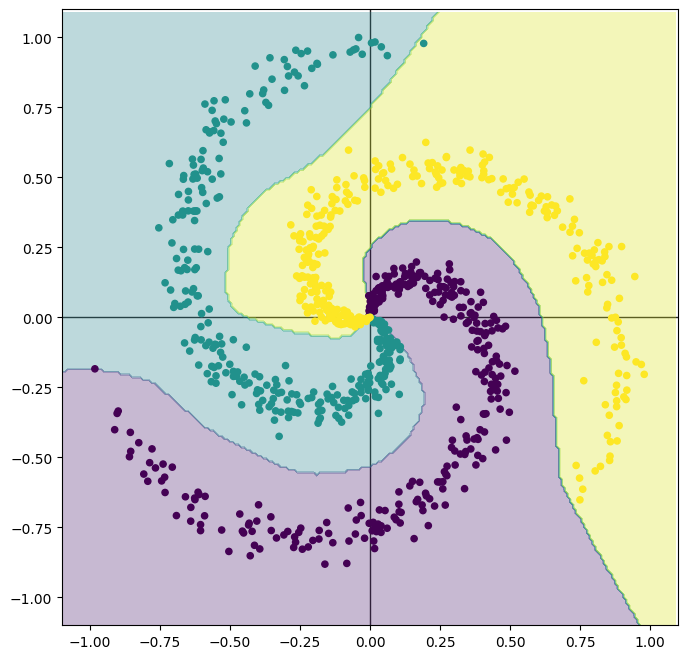

In [18]:
# Plot trained model
print(model)
plot_model(X, y, model)

In [19]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): Linear(in_features=2, out_features=3, bias=True)
)


Remove output layer

In [20]:
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))

In [21]:
print(newmodel)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)


In [22]:
newmodel.cpu()

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
)

Inspect data after transform

In [23]:
x_warp = newmodel(X.cpu()).detach()

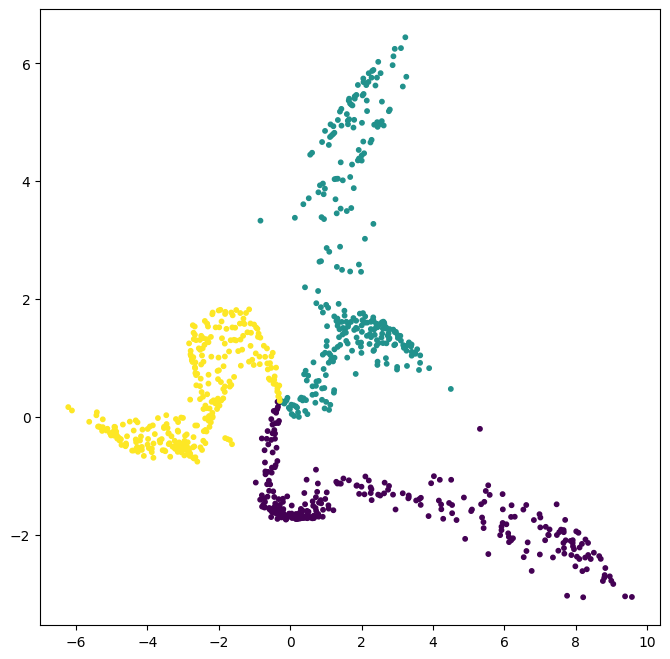

In [24]:
plt.rc('figure', facecolor='white')
# plt.style.use('seaborn-white')
plt.scatter(x_warp.numpy()[:, 0], x_warp.numpy()[:, 1], c=y.cpu(),
            cmap=cmap,
            s=10);

# Look again at the input data

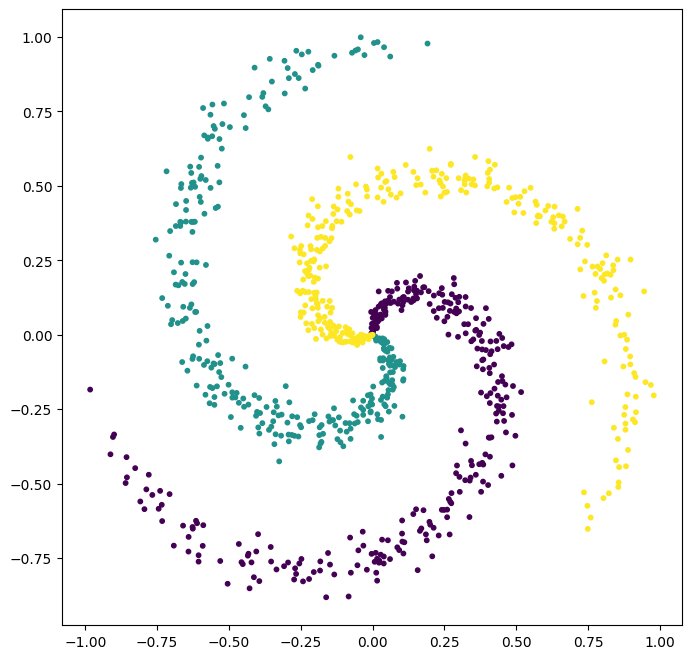

In [25]:
# plt.style.use('seaborn-white')
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=y.cpu(),
            cmap=cmap,
            s=10);

# Look at how input space is transformed

## We need to:

   ## Build a grid of points across the input space
   ## Warp the input grid to the intermediate representation

In [26]:
mesh = np.arange(-1.1,1.1, 0.01)
xx,yy = np.meshgrid(mesh,mesh)

In [27]:
with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx.reshape(-1),yy.reshape(-1))).T).float()
    Z = model(data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)

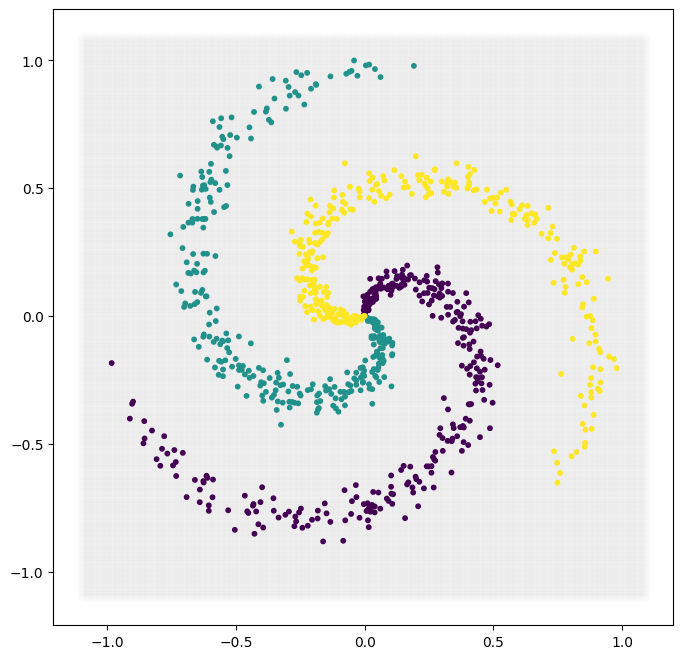

In [28]:
plt.scatter(xx.reshape(-1),yy.reshape(-1), color='lightgray', alpha=0.01)
plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=y.cpu(),
            cmap=cmap,
            s=10);

In [29]:
# Warp the xxyy grid
with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx.reshape(-1),yy.reshape(-1))).T).float()
    xxyy_warp = newmodel(data).detach()

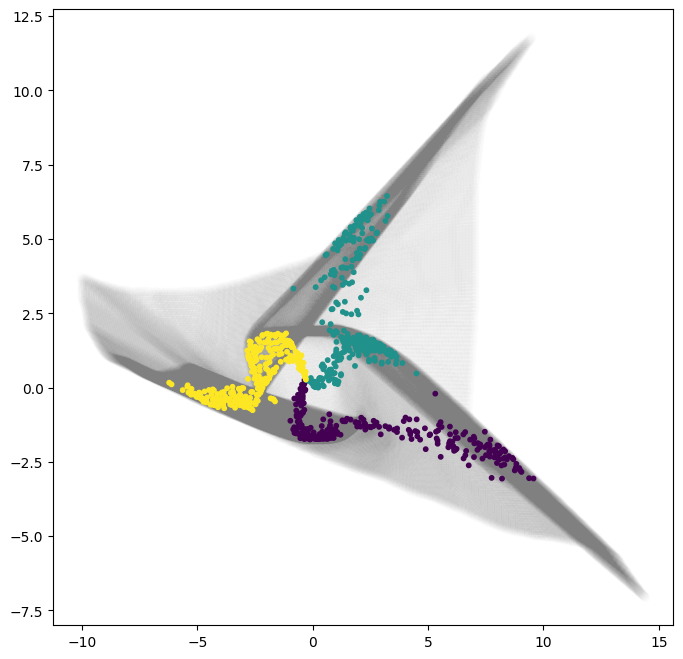

In [30]:
plt.scatter(xxyy_warp[:,0],xxyy_warp[:,1], color='gray', alpha=0.01)
plt.scatter(x_warp.numpy()[:, 0], x_warp.numpy()[:, 1], c=y.cpu(),
            cmap=cmap,
            s=10);

# Side by side plotting

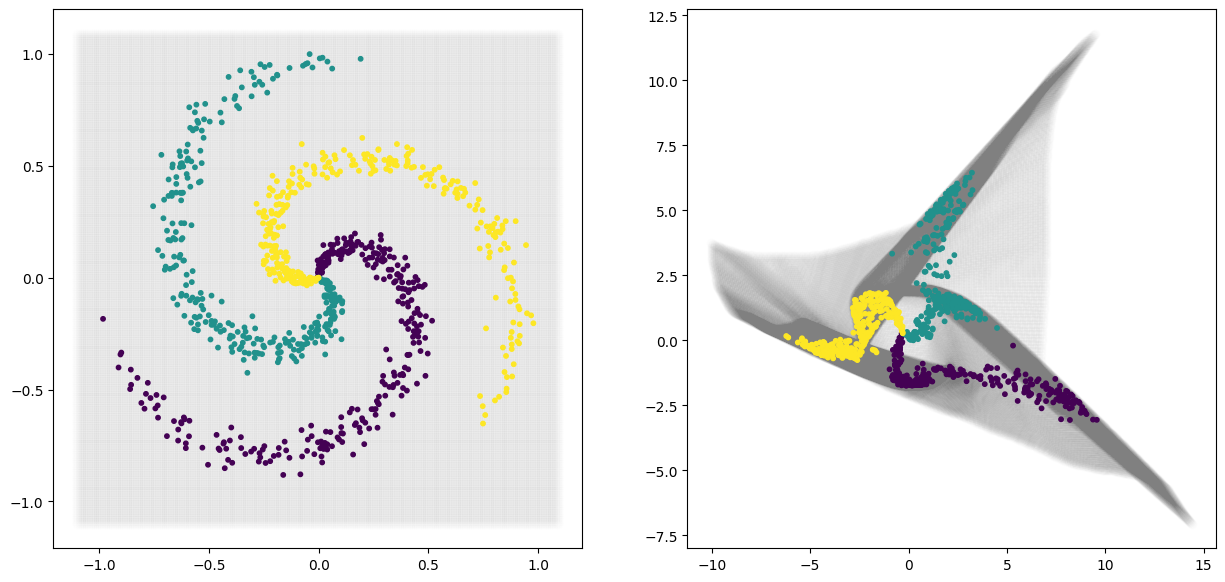

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

axes[0].scatter(xx.reshape(-1),yy.reshape(-1), color='lightgray', alpha=0.01)
axes[0].scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=y.cpu(),
            cmap=cmap,
            s=10)

axes[1].scatter(xxyy_warp[:,0],xxyy_warp[:,1], color='gray', alpha=0.01)
axes[1].scatter(x_warp.numpy()[:, 0], x_warp.numpy()[:, 1], c=y.cpu(),
            cmap=cmap,
            s=10);